In [1]:
print("""
@Title        : Time Series Analysis and Forecasting
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2023-12-24 00:39:34
@Description  : 
""")


@Title        : Time Series Analysis and Forecasting
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2023-12-24 00:39:34
@Description  : 



## Time series decomposition

In [2]:
import pandas as pd
import quandl
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
with open('../../token/quandl.txt', 'r') as f:
    token = f.read()
quandl.ApiConfig.api_key = token

In [3]:
df = (
    pd.read_csv('../data/UNRATENSA.csv', parse_dates=['DATE'], index_col='DATE')
    .rename_axis('Date', axis=0)
    .rename(columns={'UNRATENSA': 'unemp_rate'}))
df.sample(5)

,unemp_rate
Date,
2018-06-01,4.2
2014-01-01,7.0
2012-02-01,8.7
2015-11-01,4.8
2012-04-01,7.7


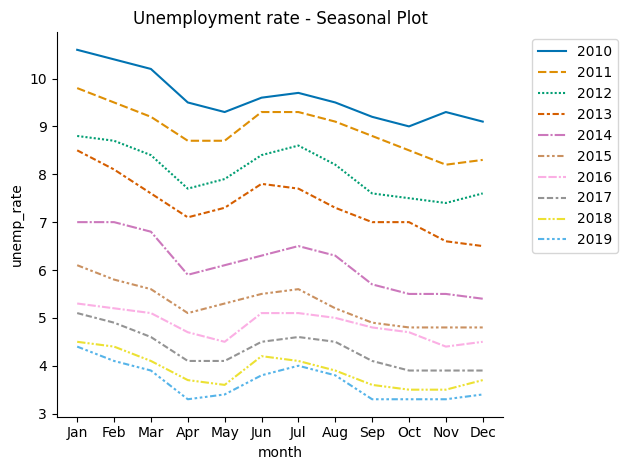

In [4]:
temp_df = df.copy()
temp_df['year'] = temp_df.index.year
temp_df['month'] = temp_df.index.strftime('%b')

sns.lineplot(data=temp_df,
             x='month',
             y='unemp_rate',
             hue='year',
             style='year',
             legend='full',
             palette='colorblind')
plt.title('Unemployment rate - Seasonal Plot')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.tight_layout()

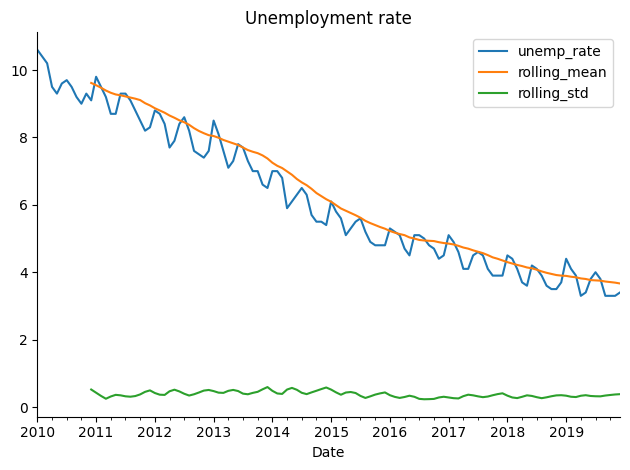

In [5]:
WINDOW_SIZE = 12
df['rolling_mean'] = df['unemp_rate'].rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df['unemp_rate'].rolling(window=WINDOW_SIZE).std()

df.plot(title='Unemployment rate')
sns.despine()
plt.tight_layout()

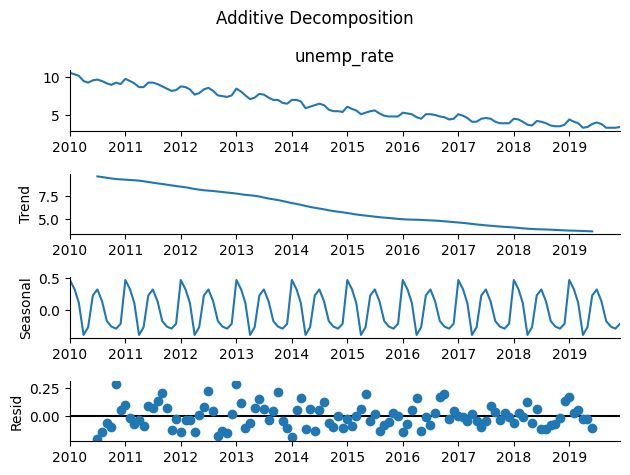

In [6]:
decomposition_results = seasonal_decompose(df['unemp_rate'],
                                           model='additive')
(
    decomposition_results
    .plot()
    .suptitle('Additive Decomposition')
)
sns.despine()
plt.tight_layout()

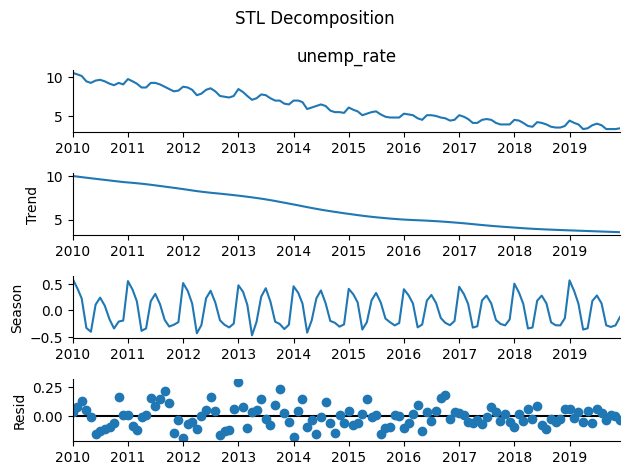

In [7]:
from statsmodels.tsa.seasonal import STL

stl_decomposition = STL(df['unemp_rate']).fit()
stl_decomposition.plot().suptitle('STL Decomposition')
sns.despine()
plt.tight_layout()

比较有鲁棒性和没有鲁棒性的分解

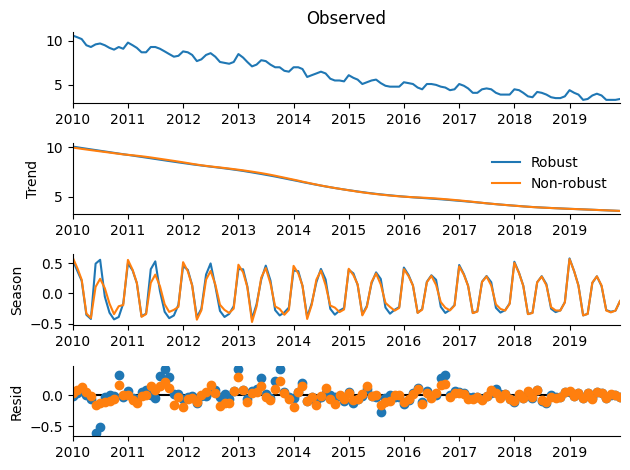

In [8]:
def add_second_stl_to_plot(fig, fitted_stl, labels):
    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(fitted_stl, comp)
        if comp == 'resid':
            ax.plot(series, marker='o', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(labels, frameon=False)
                

stl_robust = STL(df[['unemp_rate']], robust=True).fit()
stl_non_robust = STL(df[['unemp_rate']], robust=False).fit()
fig = stl_robust.plot()
add_second_stl_to_plot(fig, stl_non_robust, ['Robust', 'Non-robust'])
sns.despine()
plt.tight_layout()

Hodrick-Prescott 滤波器——虽然这种方法并不是真正的季节性分解方法，但它是一种数据平滑技术，用于消除与经济周期相关的短期波动。 通过消除这些，我们可以揭示长期趋势。 HP 滤波器常用于宏观经济学。 您可以在 `statsmodels` 的 `hpfilter` 函数中找到它的实现。

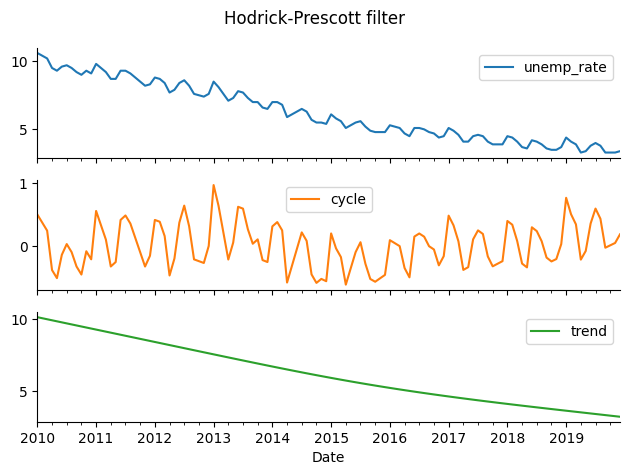

In [9]:
from statsmodels.tsa.filters.hp_filter import hpfilter

hp_df = df[['unemp_rate']].copy()
hp_df['cycle'], hp_df['trend'] = hpfilter(hp_df['unemp_rate'], 129600)
hp_df.plot(subplots=True, title='Hodrick-Prescott filter')

sns.despine()
plt.tight_layout()

## Testing for stationarity in time series

In [10]:
from utils.test import kpss_test, adf_test, test_autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [11]:
adf_test(df['unemp_rate'])

Test Statistic             -2.053411
p-value                     0.263656
# of Lags Used             12.000000
# of Observations Used    107.000000
Critical Value (1%)        -3.492996
Critical Value (5%)        -2.888955
Critical Value (10%)       -2.581393
dtype: float64

The null hypothesis of the ADF test states that the time series is not stationary. 

In [12]:
kpss_test(df['unemp_rate'])

Test Statistic           1.799224
p-value                  0.010000
# of lags                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

The null hypothesis of the KPSS test states that the time series is stationary.

d:\anaconda3\envs\fi\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


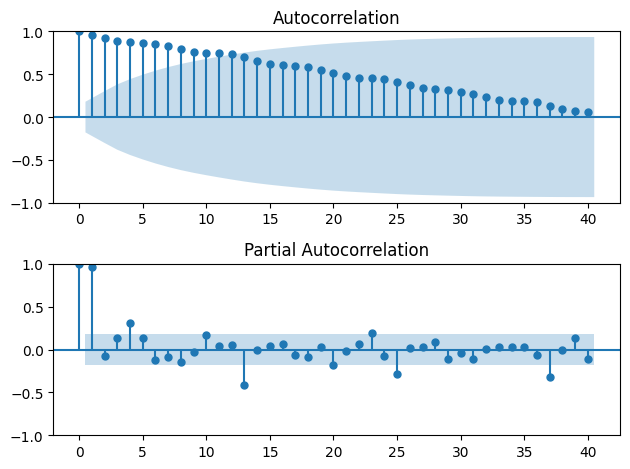

In [13]:
N_LAGS = 40
SIGNIFICANCE_LEVEl = .05
fig, ax = plt.subplots(2, 1)
plot_acf(df['unemp_rate'], ax=ax[0], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEl)
plot_pacf(df['unemp_rate'], ax=ax[1], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEl)
plt.tight_layout()

### There’s more…

In [14]:
from arch.unitroot import ADF
adf = ADF(df['unemp_rate'])
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.053
P-value                         0.264
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [15]:
from arch.unitroot import ZivotAndrews
za = ZivotAndrews(df['unemp_rate'])
print(za.summary().as_text())

        Zivot-Andrews Results        
Test Statistic                 -2.551
P-value                         0.982
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.


## Correcting for stationarity in time series

In [5]:
from utils.test import test_autocorrelation
import cpi
from datetime import date
import numpy as np
import pandas as pd

In [6]:
df = pd.read_csv('../data/gold_price_data_2000_2010.csv', 
                 parse_dates=['Date'],
                 index_col='Date')

In [7]:
DEAL_DATE = date(2010, 12, 31)

In [8]:
df['dt_index'] = pd.to_datetime(df.index)

In [9]:
df['price_deflated'] = df.apply(
    lambda x: cpi.inflate(x['price'], x['dt_index'], DEAL_DATE), axis=1)

<AxesSubplot:title={'center':'Gold Price (deflated)'}, xlabel='Date'>

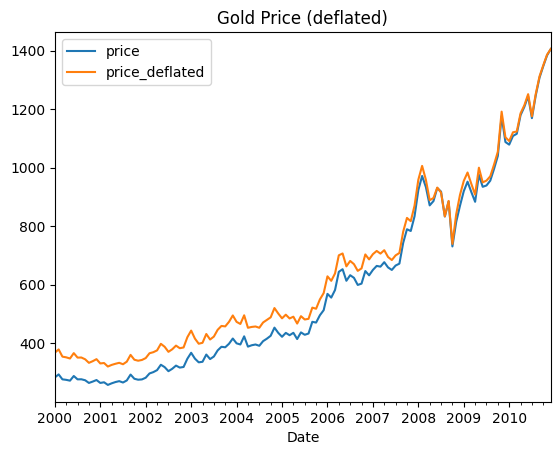

In [10]:
(
    df.loc[:, ['price', 'price_deflated']]
    .plot(title='Gold Price (deflated)')
)

NameError: name 'plt' is not defined

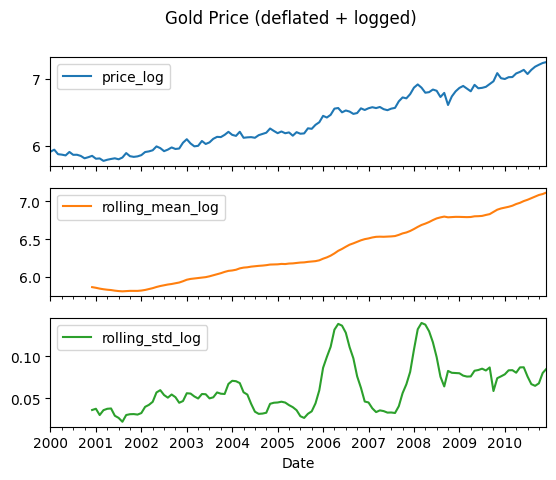

In [11]:
WINDOW = 12
selected_columns = ['price_log', 'rolling_mean_log',
                    'rolling_std_log']

df['price_log'] = np.log(df['price_deflated'])
df['rolling_mean_log'] = df['price_log'].rolling(window=WINDOW).mean()
df['rolling_std_log'] = df['price_log'].rolling(window=WINDOW).std()

(
    df[selected_columns]
    .plot(title='Gold Price (deflated + logged)',
          subplots=True)
)
plt.tight_layout()

d:\anaconda3\envs\fi\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


ADF test statistics: 0.92 (p-val: 0.99)
KPSS test statistic: 1.03 (p-val: 0.01)


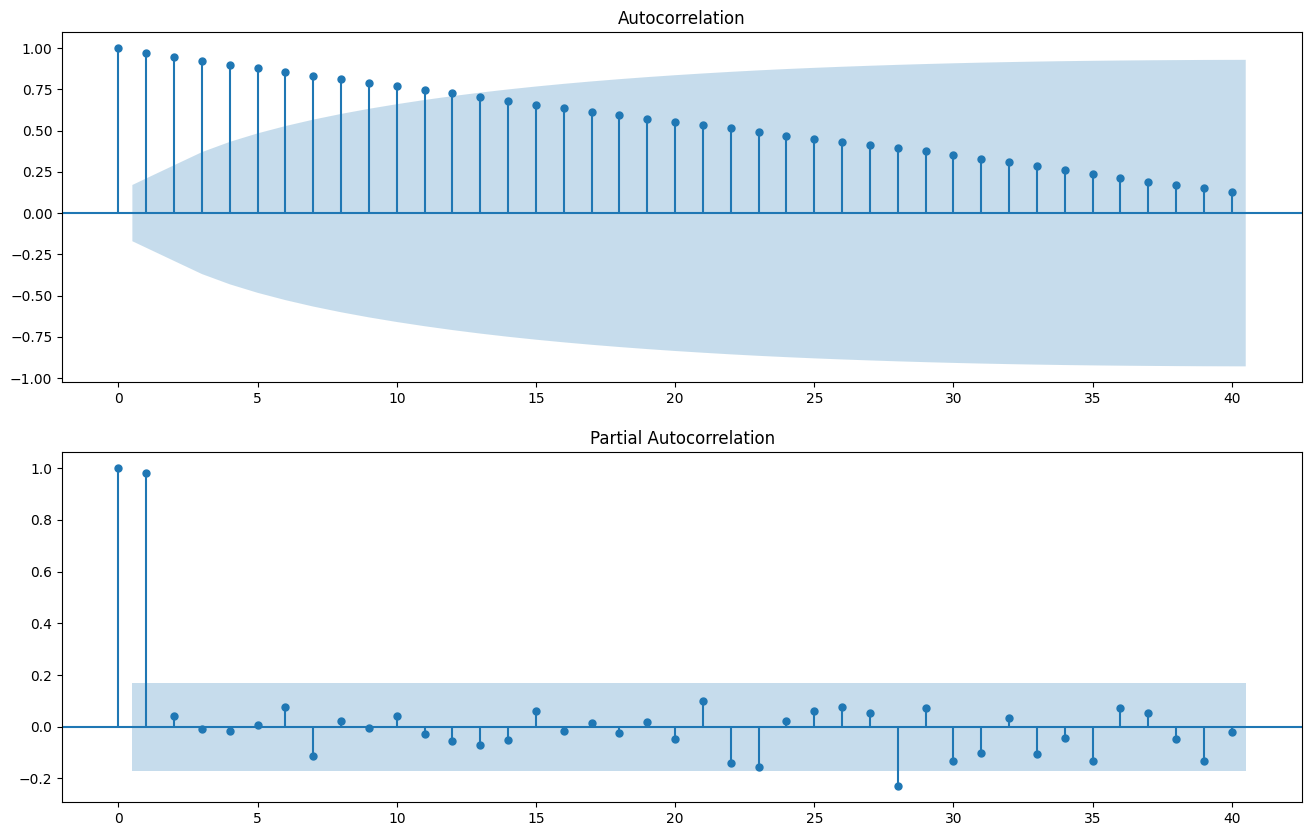

In [ ]:
fig = test_autocorrelation(df['price_log'])

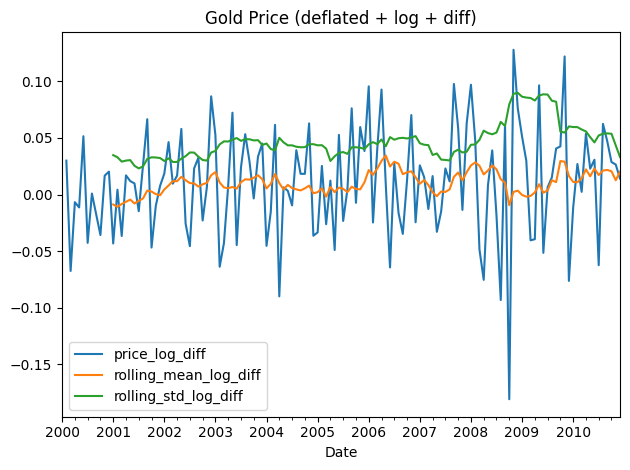

In [ ]:
selected_columns = ['price_log_diff', 'rolling_mean_log_diff', 
                    'rolling_std_log_diff']
df['price_log_diff'] = df['price_log'].diff(1)
df['rolling_mean_log_diff'] = df['price_log_diff'].rolling(window=WINDOW).mean()
df['rolling_std_log_diff'] = df['price_log_diff'].rolling(window=WINDOW).std()
df[selected_columns].plot(title='Gold Price (deflated + log + diff)')
plt.tight_layout()

d:\anaconda3\envs\fi\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


ADF test statistics: -9.45 (p-val: 0.00)
KPSS test statistic: 0.37 (p-val: 0.09)


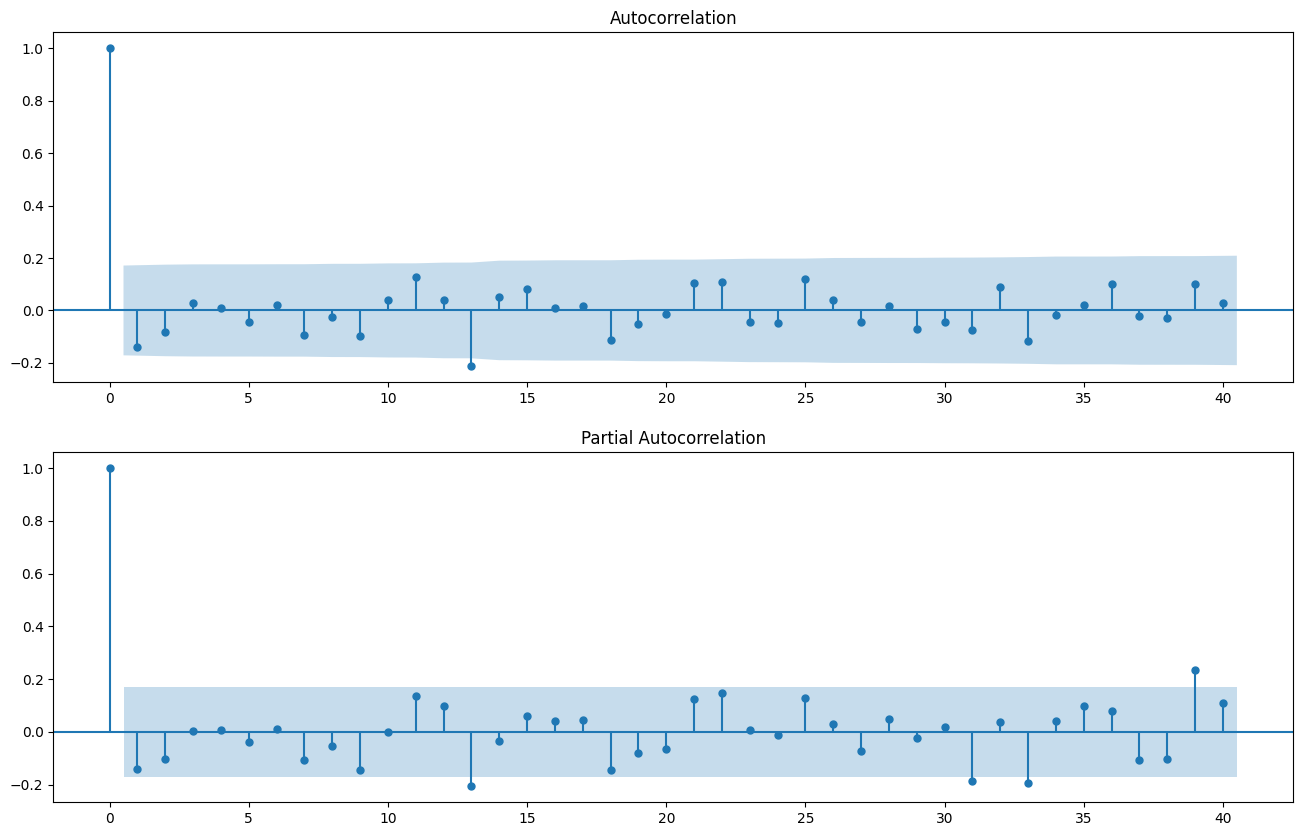

In [ ]:
fig = test_autocorrelation(df['price_log_diff'].dropna())

In [16]:
from pmdarima.arima import ndiffs, nsdiffs

print(f"Suggested # of differences (ADF): {ndiffs(df['price'], test='adf')}")
print(f"Suggested # of differences (KPSS): {ndiffs(df['price'], test='kpss')}")
print(f"Suggested # of differences (PP): {ndiffs(df['price'], test='pp')}")

Suggested # of differences (ADF): 1
Suggested # of differences (KPSS): 2
Suggested # of differences (PP): 1


The library also contains two tests for seasonal differences:
- Osborn, Chui, Smith, and Birchenhall (OCSB)
- Canova-Hansen (CH)

In [19]:
print(f"Suggested # of differences (OSCB): {nsdiffs(df['price'], m=12, test='ocsb')}")
print(f"Suggested # of differences (CH): {nsdiffs(df['price'], m=12, test='ch')}")

Suggested # of differences (OSCB): 0
Suggested # of differences (CH): 0


## 使用指数平滑方法对时间序列建模

In [44]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
df = pd.read_csv('../data/UNRATENSA.csv', index_col='DATE',
                 parse_dates=['DATE'])

In [45]:
TEST_LENGTH = 12
df.index.freq = 'MS'
df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

In [69]:
ses_1 = SimpleExpSmoothing(df_train).fit(smoothing_level=.5)
# `smoothing_level` 平滑指数，可以手动选择
ses_forecast_1 = ses_1.forecast(TEST_LENGTH)

ses_2 = SimpleExpSmoothing(df_train).fit()
# 平滑指数自动优化，不需要手动选择，基于 SSE
ses_forecast_2 = ses_2.forecast(TEST_LENGTH)

ses_1.params_formatted

,name,param,optimized
smoothing_level,alpha,0.500000,False
initial_level,l.0,10.358112,True


In [47]:
ses_1.summary()

Dep. Variable:,UNRATENSA,No. Observations:,108
Model:,SimpleExpSmoothing,SSE,15.032
Optimized:,True,AIC,-208.973
Trend:,None,BIC,-203.609
Seasonal:,None,AICC,-208.584
Seasonal Periods:,None,Date:,"Thu, 04 Jan 2024"
Box-Cox:,False,Time:,21:39:54
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,10.358112,l.0,True


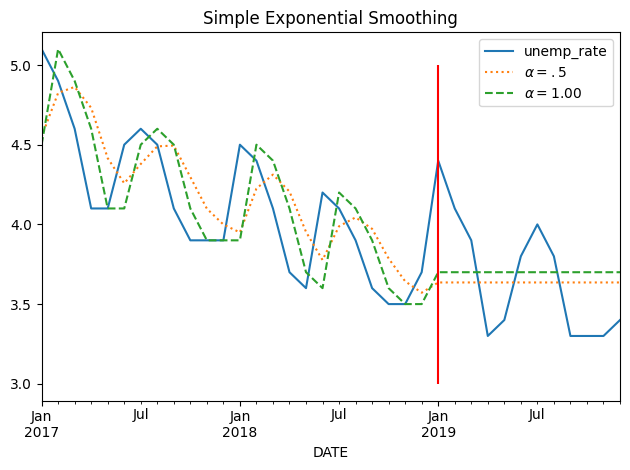

In [77]:
ses_df = df.copy()
ses_df['ses_1'] = ses_1.fittedvalues.append(ses_forecast_1)
ses_df['ses_2'] = ses_2.fittedvalues.append(ses_forecast_2)

opt_alpha = ses_2.model.params['smoothing_level']

fig, ax = plt.subplots()
ses_df['2017':].plot(style=['-', ':', '--'],
                     ax=ax, title='Simple Exponential Smoothing')
labels = ['unemp_rate', r'$\alpha=.5$', r'$\alpha={:.2f}$'.format(opt_alpha)]
ax.vlines(x='2019', ymax=5, ymin=3, color='red')
ax.legend(labels)
plt.tight_layout()

In [78]:
# Holt class (which is a wrapper around the more general ExponentialSmoothing class)
hs_1 = Holt(df_train).fit() # 默认是线性的，自动最优化
hs_forecast_1 = hs_1.forecast(TEST_LENGTH)

hs_2 = Holt(df_train, exponential=True).fit()
hs_forecast_2 = hs_2.forecast(TEST_LENGTH)

hs_3 = Holt(df_train, exponential=False, damped_trend=True).fit()
hs_forecast_3 = hs_3.forecast(TEST_LENGTH)

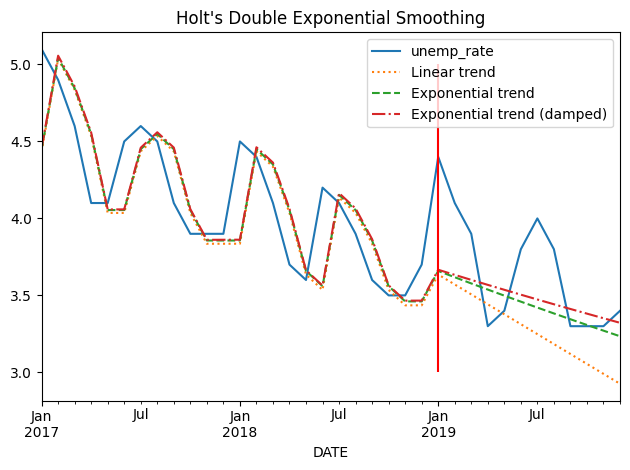

In [79]:
hs_df = df.copy()
hs_df['hs_1'] = hs_1.fittedvalues.append(hs_forecast_1)
hs_df['hs_2'] = hs_2.fittedvalues.append(hs_forecast_2)
hs_df['hs_3'] = hs_3.fittedvalues.append(hs_forecast_3)

fig, ax = plt.subplots()
hs_df['2017':].plot(style=['-', ':', '--', '-.'],
                    ax=ax, title='Holt\'s Double Exponential Smoothing')
ax.vlines(x='2019', ymax=5, ymin=3, color='red')
labels = ['unemp_rate', 'Linear trend', 'Exponential trend', 'Exponential trend (damped)']
ax.legend(labels)
plt.tight_layout()

In [80]:
SEASONAL_PERIODS = 12
hw_1 = ExponentialSmoothing(df_train, trend='mul',
                            seasonal='add', seasonal_periods=SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(TEST_LENGTH)

hw_2 = ExponentialSmoothing(df_train, trend='mul', seasonal='add',
                            seasonal_periods=SEASONAL_PERIODS,
                            damped_trend=True).fit()
hw_forecast_2 = hw_2.forecast(TEST_LENGTH)

When creating an instance of the `ExponentialSmoothing` class, we can additionally pass in the `use_boxcox` argument to automatically apply the Box-Cox transformation to the analyzed time series. Alternatively, we could use the log transformation by passing the "`log`" string to the same argument.

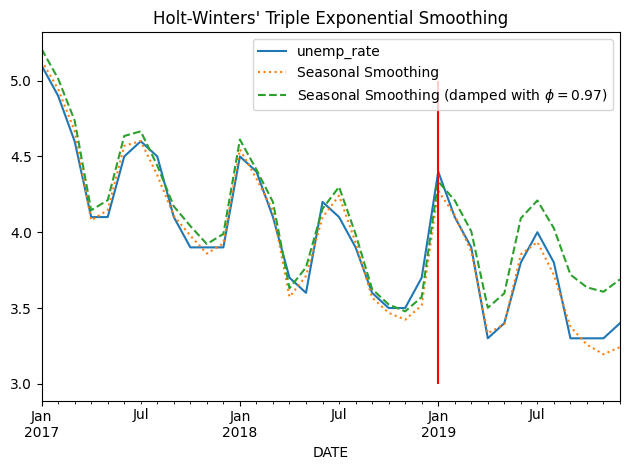

In [81]:
hw_df = df.copy()
hw_df["hw_1"] = hw_1.fittedvalues.append(hw_forecast_1)
hw_df["hw_2"] = hw_2.fittedvalues.append(hw_forecast_2)

fig, ax = plt.subplots()
hw_df["2017":].plot(
    style=["-",":","--"], ax=ax,
    title="Holt-Winters' Triple Exponential Smoothing"
)
phi = hw_2.model.params["damping_trend"]
labels = [
    "unemp_rate",
    "Seasonal Smoothing",
    f"Seasonal Smoothing (damped with $\phi={phi:.2f}$)"
]
ax.vlines(x='2019', ymax=5, ymin=3, color='red')
ax.legend(labels)
plt.tight_layout()

In the preceding plot, we can see that now the seasonal patterns were also incorporated into the forecasts.

### There’s more...

we could approach the task differently, that is, using a procedure called AutoETS. 无需赘述，该过程的目标是根据我们预先提供的一些约束条件，找到最适合的 ETS 模型。

In [82]:
from sktime.forecasting.ets import AutoETS
from sklearn.metrics import mean_absolute_percentage_error

In [83]:
auto_ets = AutoETS(auto=True, n_jobs=-1, sp=12)

In [86]:
df_train.to_period()

,UNRATENSA
DATE,
2010-01,10.6
2010-02,10.4
2010-03,10.2
2010-04,9.5
2010-05,9.3
...,...
2018-08,3.9
2018-09,3.6
2018-10,3.5
